In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import numpy as np

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

# Setup

In [2]:
images = Path('datasets/etri12-dataset')
outputs = Path('outputs/etri12-dataset/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['superpoint_max']
matcher_conf = match_features.confs['superpoint+lightglue']

# 3D mapping

30 mapping images


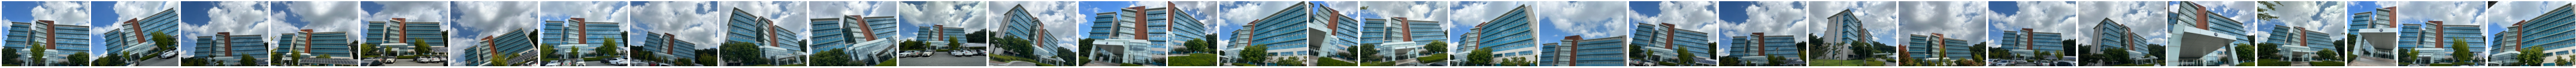

In [3]:
references = [p.relative_to(images).as_posix() for p in (images / 'mapping/').iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25)

In [4]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)

[2023/08/21 14:18:52 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-rmax1600',
 'preprocessing': {'grayscale': True, 'resize_force': True, 'resize_max': 1600}}


Loaded SuperPoint model


  0%|          | 0/30 [00:00<?, ?it/s]

[2023/08/21 14:18:56 hloc INFO] Finished exporting features.


PosixPath('outputs/etri12-dataset/features.h5')

In [5]:
pairs_from_exhaustive.main(sfm_pairs, image_list=references)

[2023/08/21 14:18:58 hloc INFO] Found 435 pairs.


In [6]:
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2023/08/21 14:19:00 hloc INFO] Matching local features with configuration:
{'model': {'features': 'superpoint', 'name': 'lightglue'},
 'output': 'matches-superpoint-lightglue'}
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /home/minseong/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv-pth


  0%|          | 0.00/45.3M [00:00<?, ?B/s]

  0%|          | 0/435 [00:00<?, ?it/s]

[2023/08/21 14:19:29 hloc INFO] Finished exporting matches.


[2023/08/21 14:19:29 hloc INFO] Creating an empty database...
[2023/08/21 14:19:31 hloc INFO] Importing images into the database...
[2023/08/21 14:19:31 hloc INFO] Importing features into the database...


  0%|          | 0/30 [00:00<?, ?it/s]

[2023/08/21 14:19:31 hloc INFO] Importing matches into the database...


  0%|          | 0/435 [00:00<?, ?it/s]

[2023/08/21 14:19:32 hloc INFO] Performing geometric verification of the matches...
[2023/08/21 14:19:33 hloc INFO] Running 3D reconstruction...
[2023/08/21 14:19:55 hloc INFO] Reconstructed 1 model(s).
[2023/08/21 14:19:55 hloc INFO] Largest model is #0 with 30 images.
[2023/08/21 14:19:55 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 30
	num_cameras = 4
	num_points3D = 3755
	num_observations = 36401
	mean_track_length = 9.69401
	mean_observations_per_image = 1213.37
	mean_reprojection_error = 1.02288
	num_input_images = 30


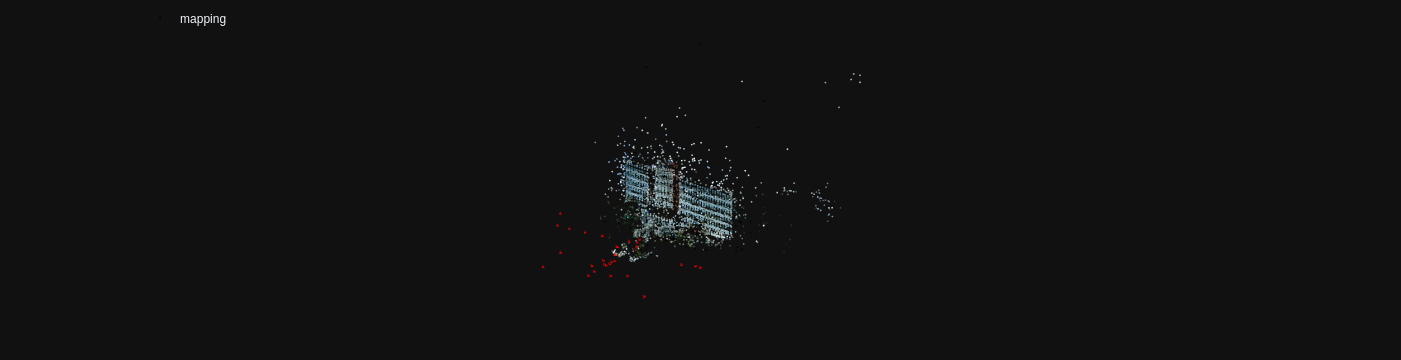

In [7]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

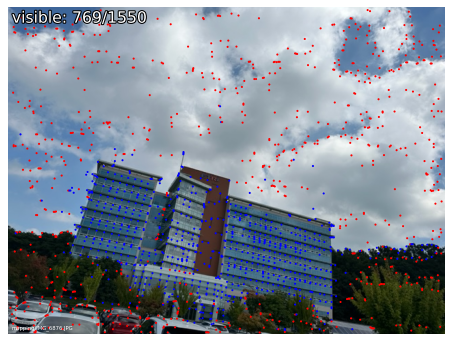

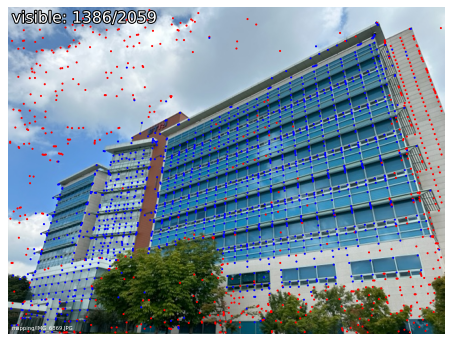

In [8]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)

# Localization

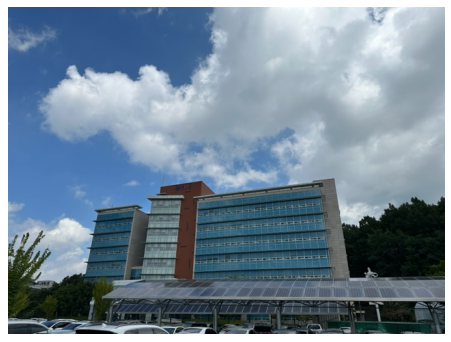

In [9]:
# url = "https://upload.wikimedia.org/wikipedia/commons/5/53/Paris_-_Basilique_du_Sacr%C3%A9_Coeur%2C_Montmartre_-_panoramio.jpg"
# try other queries by uncommenting their url
# url = "https://upload.wikimedia.org/wikipedia/commons/5/59/Basilique_du_Sacr%C3%A9-C%C5%93ur_%285430392880%29.jpg"
# url = "https://upload.wikimedia.org/wikipedia/commons/8/8e/Sacr%C3%A9_C%C5%93ur_at_night%21_%285865355326%29.jpg"
query = 'query/IMG_6874.JPG'
# !mkdir -p $images/query && wget $url -O $images/$query -q
plot_images([read_image(images / query)], dpi=75)

Again, we extract features for the query and match them exhaustively.

In [10]:
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

[2023/08/21 14:19:56 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-rmax1600',
 'preprocessing': {'grayscale': True, 'resize_force': True, 'resize_max': 1600}}


Loaded SuperPoint model


  0%|          | 0/1 [00:00<?, ?it/s]

[2023/08/21 14:19:57 hloc INFO] Finished exporting features.
[2023/08/21 14:19:57 hloc INFO] Found 30 pairs.
[2023/08/21 14:19:57 hloc INFO] Matching local features with configuration:
{'model': {'features': 'superpoint', 'name': 'lightglue'},
 'output': 'matches-superpoint-lightglue'}


  0%|          | 0/30 [00:00<?, ?it/s]

[2023/08/21 14:19:59 hloc INFO] Finished exporting matches.


found 1161/1574 inlier correspondences.


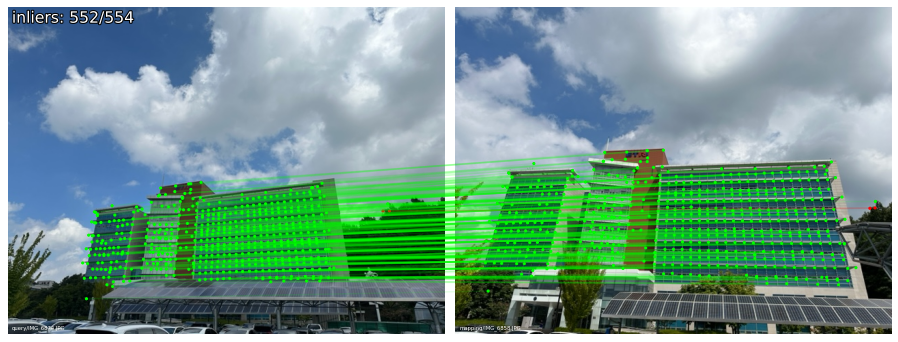

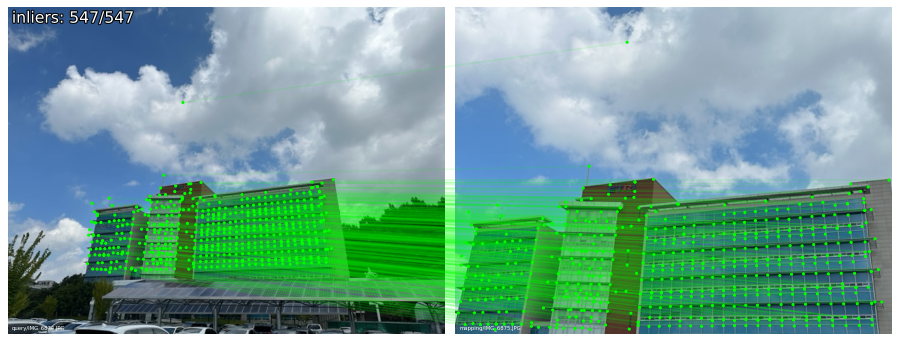

In [11]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r).image_id for r in references]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

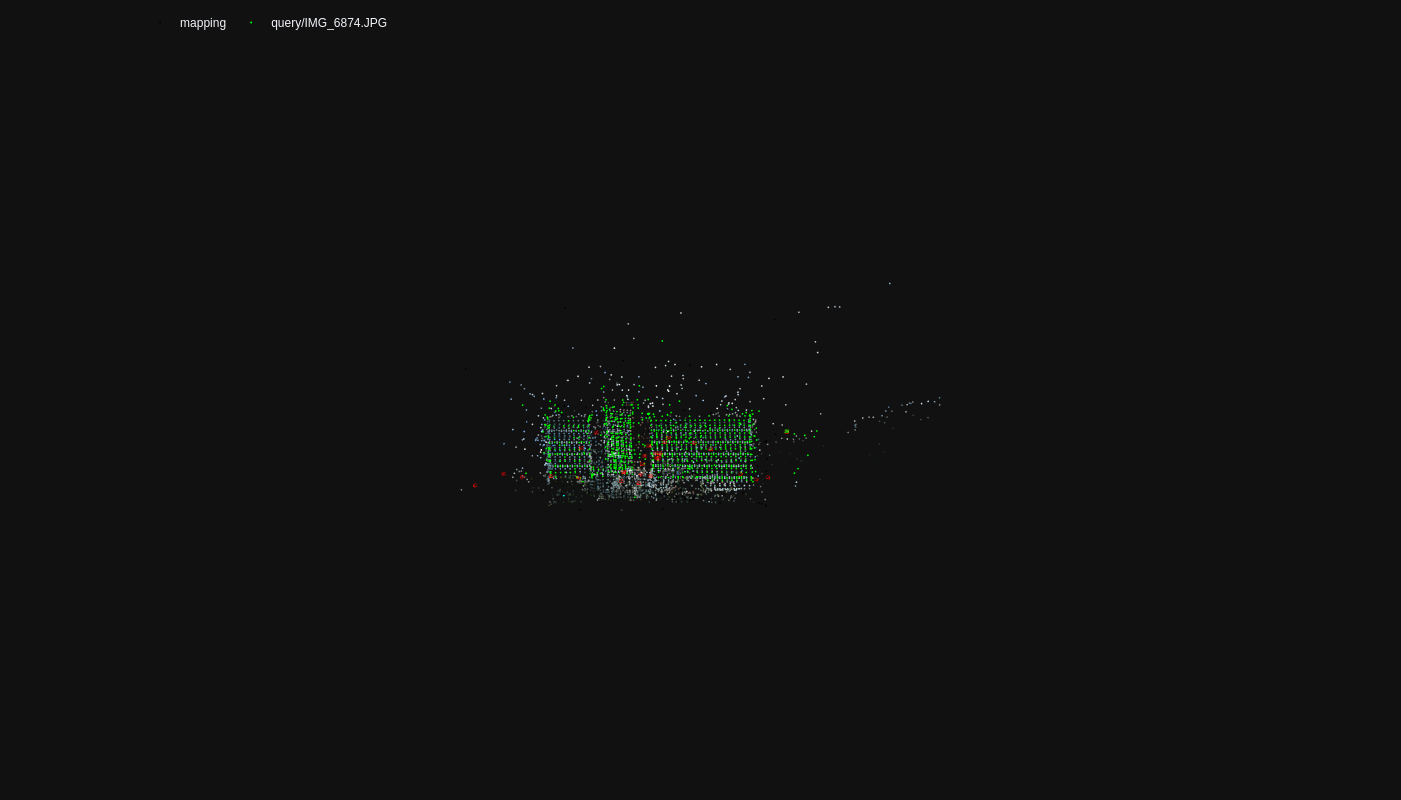

In [12]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query, fill=True)
# visualize 2D-3D correspodences
inl_3d = np.array([model.points3D[pid].xyz for pid in np.array(log['points3D_ids'])[ret['inliers']]])
viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=query)
fig.show()